このPython コードは、PyMC を使ってMCMCサンプリングを行います。
* 2025年8月時点では、Google Colaboratory環境では PyMC がそのまま使えますので、実行可能です。
* ローカルな計算機環境では、PyMC パッケージが含まれていないのが一般的です。
    * 例えば、Anaconda などの Distribution では、以下の例の様に、PyMC環境を用意する必要があります。
        ```
        conda create -c conda-forge -n pymc_env pymc
        conda activate pymc_env
        conda install conda-forge::ipywidgets
        conda install scikit-learn
        ```
        * これで VS codeの実行時のPython環境に、```pymc_env```を選択します。

In [1]:
############################################
BaseDir      = 'IntroDDSJpn/Chap02/'
OutputDir    = '2PyMC-0502Line-01/'
FileBaseName = '2PyMC-0502Line-01'

* Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [2]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

ipynb file path = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/


* 必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
print('numpy      Ver.', np.__version__)
#
############################################
# https://docs.pymc.io/
import pymc as pm
import time
print('pymc3      Ver.', pm.__version__)
#
############################################
import pickle
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.10.0
numpy      Ver. 1.26.4


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc3      Ver. 5.16.1
FilePath = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-0502Line-01/
  making d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-0502Line-01/


最確値を書式化して文字列として返す関数
```
Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False )
```
*   返値: 書式化された文字列を返す。
*   v_mean: 平均値
*   v_std:  標準偏差
*   s_unit: 値の単位(文字列)
*   std_2digit=True: 標準偏差を2桁表示。Falseにすると1桁表示
*   latex=False: テキスト文字列として出力。Trueでは、図などでlatex表示できる文字列で出力。

In [4]:
def Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False ):
  #
  # 平均値の冪数
  order_mean = np.floor( np.log10(v_mean) )
  # print( 'order_mean=', order_mean )
  #
  # 標準偏差の冪数
  if std_2digits:
    # 標準偏差を有効2桁表示
    order_std  = np.floor( np.log10(v_std) - 1.0 )
  else:
    # 標準偏差を有効1桁表示
    order_std  = np.floor( np.log10(v_std) - 0.0 )
  # print( 'order_std=', order_std )
  #
  # 平均値の冪数と標準偏差の冪数の符号が同じか?
  if order_mean * order_std > 0.0:
    # 例1
    # v_mean = 4.60572E5
    # v_std  = 8.96E3
    # 例2
    # v_mean = 4.605723E-2
    # v_std  = 8.96E-5
    multi_order = order_std+1
    #
    # 共通する冪数
    multi = 10.0**multi_order
    #
    # 共通する冪数で規格化
    v_mean = v_mean / multi
    v_std  = v_std  / multi
    #
    # 共通した冪数で指数をくくって、係数は少数第1位
    if latex:
      out_str = r'(%+.1f $\pm$ %.1f)$\times10^{%+d}$ ' % (v_mean, v_std, multi_order) + s_unit
    else:
      out_str = '(%+.1f +/- %.1f)x10^(%+d) ' % (v_mean, v_std, multi_order) + s_unit
    #
  else:
    # 平均値の冪数と標準偏差の冪数の符号が異なる
    # 例2
    # v_mean = 4.605723
    # v_std  = 0.0896
    fmt_std1 = r'$%%+.%df$' % -order_std
    fmt_std2 = r'$%%.%df$'  % -order_std
    if latex:
      fmt_str = fmt_std1 + r' $\pm$ ' + fmt_std2 + ' ' + s_unit
    else:
      fmt_str = fmt_std1 + ' +/- ' + fmt_std2 + ' ' + s_unit
    #
    out_str = fmt_str % (v_mean, v_std)
  #
  return out_str

---
直線回帰の例1

1. 直線の関数:  $f(x;a,b)=a\,x+b$
    * $a$: 勾配 (真値: $a_{\rm true}=2.0$)
    * $b$: 切片 (真値: $b_{\rm true}=0.3$)

2. データの諸元
    * $x=-2.5 \sim +2.5$
    * データ点数: $N=501$

In [5]:
############################################
N = 501
#
X = np.linspace(-2.5,2.5, num=N, endpoint=True )
#
print('X: %.3f ~ %.3f (N = %d)' %
      (np.amin(X), np.amax(X), X.size))
print('X: mean = %.3f, std = %.3f' %
      (np.mean(X), np.std(X)))
#
a_true = 2.0
b_true = 0.3
#
print('gradient  a_true = %.3f' % a_true)
print('intercept b_true = %.3f' % b_true)
#
Y_true = a_true * X + b_true
#
print('Y_true: %.3f ~ %.3f (N = %d)' %
      (np.amin(Y_true), np.amax(Y_true), Y_true.size))
print('Y_true: mean = %.3f, std = %.3f' %
      (np.mean(Y_true), np.std(Y_true)))

X: -2.500 ~ 2.500 (N = 501)
X: mean = 0.000, std = 1.446
gradient  a_true = 2.000
intercept b_true = 0.300
Y_true: -4.700 ~ 5.300 (N = 501)
Y_true: mean = 0.300, std = 2.893


3. 重畳する正規ノイズ ${\cal N}(\mu=0.0,\sigma=1.0)$
    * 設定平均値:  $\mu=0.0$
    * 設定標準偏差:  $\sigma=1.0$

4. 解析対象データ: $y_{i}=f(x_{i};a_{\rm true}, b_{\rm true})+{\cal N}(\mu=0.0,\sigma=1.0)$

In [6]:
############################################
# np.random.seed(1)
#
sigma_noise = 1E0
# sigma_noise = 1E-1
#
Y_noise = np.random.normal( loc=0,
                           scale=sigma_noise,
                           size=N )
Y_noise_mean = np.mean(Y_noise)
Y_noise_std  = np.std(Y_noise)
#
print('Y_noise: %.3f ~ %.3f (N = %d)' %
      (np.amin(Y_noise), np.amax(Y_noise), Y_noise.size))
print('Y_noise: mean = %.3f, std = %.3f' %
      (Y_noise_mean, Y_noise_std))
#

#
Y = Y_true + Y_noise
#
print('Y: %.3f ~ %.3f (N = %d)' %
      (np.amin(Y), np.amax(Y), Y.size))
print('Y: mean = %.3f, std = %.3f' %
      (np.mean(Y), np.std(Y)))

Y_noise: -2.861 ~ 2.691 (N = 501)
Y_noise: mean = 0.028, std = 1.025
Y: -7.421 ~ 7.458 (N = 501)
Y: mean = 0.328, std = 3.095


5. 真値データと解析データの描画と出力

$Y_{true}: a_{true}=2.000, b_{true}=0.300$


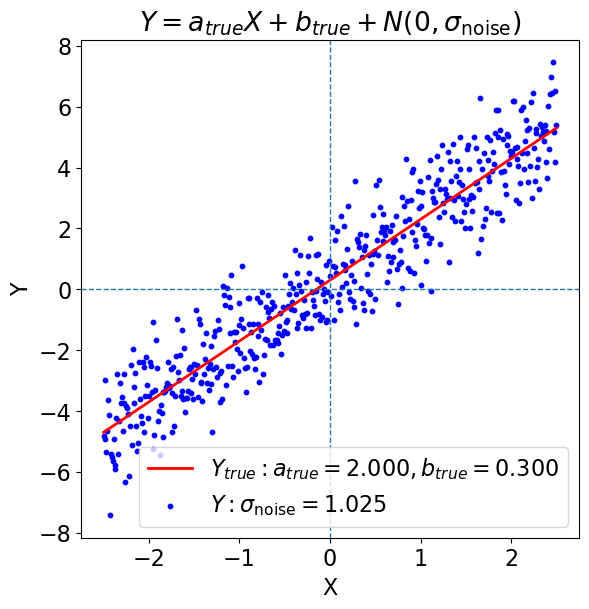

In [7]:
######################################
plt.rcParams['font.size'] = 16
#
fig = plt.figure( figsize=(6,6) )
fig.subplots_adjust(left=0.15, right=0.98,
                    top=0.93, bottom=0.1)
#
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
#
label = r'$Y_{true}: a_{true}=%.3f, b_{true}=%.3f$' % (a_true, b_true)
print( label )
ax1.plot(X, Y_true, color='red',
         linewidth=2.0,
         label=r'$Y_{true}: a_{true}=%.3f, b_{true}=%.3f$' % (a_true, b_true) )
ax1.scatter(X, Y, color='blue',
            s=10.0,
            label=r'$Y: \sigma_{\rm{}noise}=%.3f$'
                   % Y_noise_std)
#
(x_left, x_right) = ax1.set_xlim()
(y_bot, y_top) = ax1.set_ylim()
#
ax1.hlines(0, x_left, x_right,
           linestyles='dashed', linewidth=1.0)
ax1.vlines(0, y_bot, y_top,
           linestyles='dashed', linewidth=1.0)
#
plt.title( r'$Y=a_{true}X+b_{true}+N(0,\sigma_{\rm{}noise})$' )
plt.legend()
#
plt.show()
#
######################################
pdfName = FilePath + FileBaseName + "-data-org.pdf"
fig.savefig( pdfName )

6. $a$, $b$の事後確率分布
$$
P(a|\boldsymbol{D})
=
\sqrt{
  \frac{
    M
    \overline{x^2}
  }{
    2\pi
    \sigma_{\rm noise}^{2}
  }
}
\exp
\left[
  -
  \frac{
    M
    \overline{x^2}
  }{
    2
    \sigma_{\rm noise}^{2}
  }
  \left(
    a-a_{0}
  \right)^2
\right]
$$

$$
P(b|\boldsymbol{D})
=
\sqrt{
  \frac{
    M
  }{
    2\pi
    \sigma_{\rm noise}^{2}
  }
}
\exp
\left[
  -
  \frac{
    M
  }{
    2
    \sigma_{\rm noise}^{2}
  }
  \left(
    b-b_{0}
  \right)^2
\right]
$$

7. $a$, $b$の事後確率分布の標準偏差
$$
\sigma_{P(a|\boldsymbol{D})}
=
\frac{
  \sigma_{\rm noise}
}{
  \sqrt{
    M
    \overline{x^2}
  }
}
$$

$$
\sigma_{P(b|\boldsymbol{D})}
=
\frac{
  \sigma_{\rm noise}
}{
  \sqrt{
    M
  }
}
$$

In [8]:
######################################
print('sigm_{noise} = %.6f' % \
      Y_noise_std )

sigma_a = Y_noise_std / \
    np.sqrt(N*np.mean(X**2))

sigma_b = Y_noise_std / np.sqrt(N)

print('sigm_{a}     = %.6f' % sigma_a )
print('sigm_{b}     = %.6f' % sigma_b )

sigm_{noise} = 1.025453
sigm_{a}     = 0.031677
sigm_{b}     = 0.045814


8. $a$, $b$の事前確率の設定-1
* $P(a)={\cal N}(\mu=0.0,\sigma=2.0)$
* $P(b)={\cal N}(\mu=0.0,\sigma=1.0)$

9. PyMCによるサンプリング-1

In [9]:
######################################
#
t0 = time.perf_counter()
#
with pm.Model() as  model:
    #
    # a_true = 2.0
    # b_true = 0.3
    # sigma_noise = 1E0
    #
    a    = pm.Normal('a', mu=0, sigma=2 )
    b    = pm.Normal('b', mu=0, sigma=1 )
    rmsd = pm.Uniform('rmsd', lower=0, upper=10)
    y    = pm.Normal('y', mu=a*X+b, sigma=rmsd, observed=Y)
    # start = pm.find_MAP()
    # step  = pm.NUTS(state=start)
    trace = pm.sample(10000, tune=1000, chains=2 )
#
t1 = time.perf_counter()
print( "elapsed time %.3f sec" % (t1-t0)  )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, rmsd]


Output()

Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


elapsed time 32.172 sec


10. サンプリング結果のsummary-1

In [10]:
######################################
summary = pm.summary(trace)
summary_a = pm.summary(trace,['a'])
summary_b = pm.summary(trace,['b'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.019,0.032,1.960,2.078,0.0,0.0,30208.0,15671.0,1.0
b,0.327,0.046,0.240,0.413,0.0,0.0,29500.0,16333.0,1.0
rmsd,1.030,0.033,0.969,1.093,0.0,0.0,31997.0,15842.0,1.0


In [11]:
######################################
a_mean = float( summary_a['mean'] )
a_sd   = float( summary_a['sd'] )
b_mean = float( summary_b['mean'] )
b_sd   = float( summary_b['sd'] )
print('a_{true} = %.6f' % a_true )
print('sigm_{a} = %.6f' % sigma_a )
print('a        =',  Format_MostProbableValue( a_mean, a_sd, '' ) )
print('b_{true} = %.6f' % b_true )
print('sigm_{b} = %.6f' % sigma_b )
print('b        =',  Format_MostProbableValue( b_mean, b_sd, '' ) )

a_{true} = 2.000000
sigm_{a} = 0.031677
a        = $+2.019$ +/- $0.032$ 
b_{true} = 0.300000
sigm_{b} = 0.045814
b        = (+32.7 +/- 4.6)x10^(-2) 


C:\Users\iakai\AppData\Local\Temp\ipykernel_57576\3506056292.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_mean = float( summary_a['mean'] )
C:\Users\iakai\AppData\Local\Temp\ipykernel_57576\3506056292.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_sd   = float( summary_a['sd'] )
C:\Users\iakai\AppData\Local\Temp\ipykernel_57576\3506056292.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_mean = float( summary_b['mean'] )
C:\Users\iakai\AppData\Local\Temp\ipykernel_57576\3506056292.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_sd   = float( summary_b['sd'] )


11. plot_trace-1

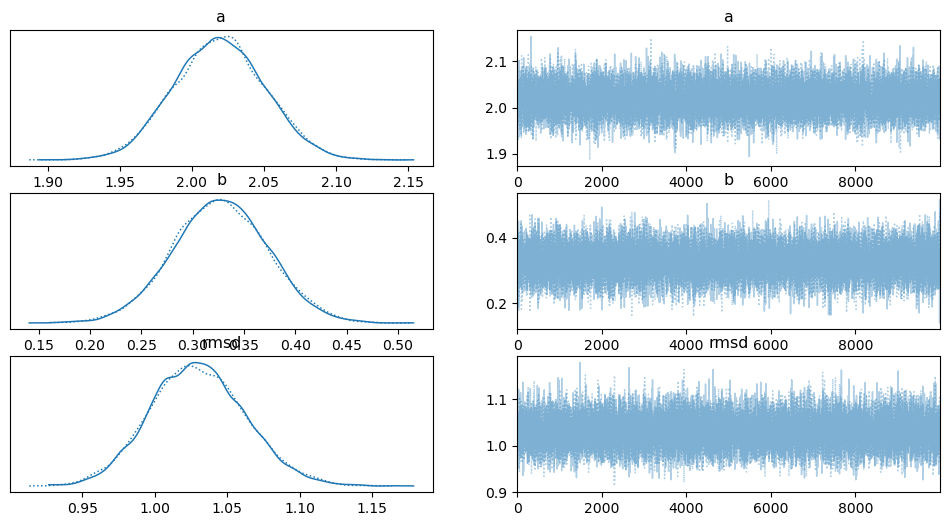

In [12]:
######################################
pm.plot_trace(trace)
#
pdfName = FilePath + FileBaseName + "-trace-1.pdf"
plt.savefig( pdfName )

---
20. $a$, $b$の事前確率の設定-2
* $P(a)={\cal U}({\rm lower}=-20.0,{\rm upper}=+20.0)$
* $P(b)={\cal U}({\rm lower}=-10.0,{\rm upper}=+10.0)$

21. PyMCによるサンプリング-2

In [13]:
######################################
t0 = time.perf_counter()
#
with pm.Model() as  model:
    #
    # a_true = 2.0
    # b_true = 0.3
    # sigma_noise = 1E0
    #
    # a    = pm.Normal('a', \
    #                  mu=0, sd=2 )
    a    = pm.Uniform('a', lower=-20, upper=20 )
    b    = pm.Uniform('b', lower=-10, upper=10 )
    rmsd = pm.Uniform('rmsd', lower=0, upper=10)
    y = pm.Normal('y', mu=a*X+b, sigma=rmsd, observed=Y)
    #
    trace = pm.sample( 10000, tune=1000, target_accept=0.7, chains=2)
#
t1 = time.perf_counter()
print( "elapsed time %.3f sec" % \
      (t1-t0))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, rmsd]


Output()

Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


elapsed time 34.195 sec


22. サンプリング結果のsummary-2

In [14]:
######################################
summary = pm.summary(trace)
summary_a = pm.summary(trace,['a'])
summary_b = pm.summary(trace,['b'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.019,0.032,1.955,2.077,0.0,0.0,29822.0,14963.0,1.0
b,0.328,0.046,0.243,0.416,0.0,0.0,29252.0,15509.0,1.0
rmsd,1.030,0.033,0.969,1.092,0.0,0.0,28432.0,14459.0,1.0


In [15]:
######################################
a_mean = float( summary_a['mean'] )
a_sd   = float( summary_a['sd'] )
b_mean = float( summary_b['mean'] )
b_sd   = float( summary_b['sd'] )
print('a_{true} = %.6f' % a_true )
print('sigm_{a} = %.6f' % sigma_a )
print('a        =',  Format_MostProbableValue( a_mean, a_sd, '' ) )
print('b_{true} = %.6f' % b_true )
print('sigm_{b} = %.6f' % sigma_b )
print('b        =',  Format_MostProbableValue( b_mean, b_sd, '' ) )

a_{true} = 2.000000
sigm_{a} = 0.031677
a        = $+2.019$ +/- $0.032$ 
b_{true} = 0.300000
sigm_{b} = 0.045814
b        = (+32.8 +/- 4.6)x10^(-2) 


C:\Users\iakai\AppData\Local\Temp\ipykernel_57576\3506056292.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_mean = float( summary_a['mean'] )
C:\Users\iakai\AppData\Local\Temp\ipykernel_57576\3506056292.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_sd   = float( summary_a['sd'] )
C:\Users\iakai\AppData\Local\Temp\ipykernel_57576\3506056292.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_mean = float( summary_b['mean'] )
C:\Users\iakai\AppData\Local\Temp\ipykernel_57576\3506056292.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_sd   = float( summary_b['sd'] )


23. plot_trace-2

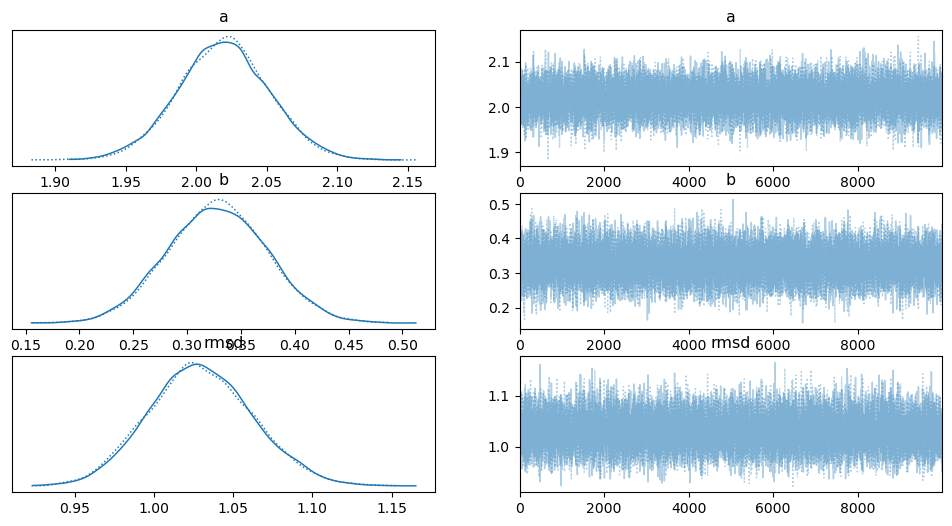

: 

In [ ]:
######################################
pm.plot_trace(trace)
#
pdfName = FilePath + FileBaseName + "-trace-2.pdf"
plt.savefig( pdfName )